# Extracting and Plotting Position-Velocity Diagrams

#### https://github.com/astropy/astropy-tutorials/blob/main/tutorials/position-velocity-diagrams/PVDiagramPlotting.ipynb

In [1]:
import pylab as plt
import numpy as np
from astropy import constants as c
from astropy import units as u
from astropy.visualization import quantity_support
from astropy import wcs
from astropy.coordinates import SkyCoord
from astropy.wcs.utils import skycoord_to_pixel
from astropy.nddata import Cutout2D
from astropy.visualization import (MinMaxInterval, SqrtStretch, SinhStretch, AsinhStretch, ImageNormalize)
import radio_beam
import regions
import matplotlib.gridspec as gridspec

# set so that these display properly on black backgrounds
plt.rcParams['figure.facecolor']='w'

from spectral_cube import SpectralCube
from pvextractor import extract_pv_slice, Path

%matplotlib inline

In [2]:
def make_subcube(filename, center=(0,0), width=10*u.arcsec, height=10*u.arcsec, angle=0*u.deg):
    cube = SpectralCube.read(filename, format='fits', use_dask=True)

    subregion = regions.RectangleSkyRegion(center, width=width, height=height, angle=angle)
    subcube = cube.subcube_from_regions([subregion])

    h = subcube.header
    dra = (1 + np.arange(h['NAXIS1']) - h['CRPIX1']) * h['CDELT1'] * 3600
    ddec = (1 + np.arange(h['NAXIS2']) - h['CRPIX2']) * h['CDELT2'] * 3600
    extent = [dra.max(), dra.min(), ddec.min(), ddec.max()]

    return subcube, extent

In [3]:
def Kepler(Mstar, Rin, Rout):
    # Keplerian velocities for a central stellar mass Mstar, with disk inner and outer radii in au
    
    dR = (Rout-Rin)/100
    R = np.arange(Rin+dR, Rout, dR)
    VKep = (np.sqrt(c.GM_sun * Mstar / (R *c.au))).to(u.km/u.s).value
        
    return R, VKep

In [4]:
def bound_velocities(Mstar, Rin, Rout):
    # Cesaroni formulation to give the min and max projected velocities for an edge-on disk
    # for a central stellar mass Mstar, with disk inner and outer radii in au
    VKep = (np.sqrt(c.GM_sun * Mstar / c.au)).to(u.km/u.s).value
    
    dR = (Rout-Rin)/100
    R = np.arange(Rin+dR, Rout, dR)
    Vbound_min = np.zeros(len(R))
    Vbound_max = np.zeros(len(R))
    
    for i,x in enumerate(R):
        z1 = np.sqrt(Rout**2-x**2)
        dz = z1/100
        z = np.arange(-z1, z1+dz, dz)
        r1 = np.sqrt(x**2 + z**2)
        v1 = VKep*(x+1.4142*z)/r1**1.5
        Vbound_min[i] = np.min(v1)
        Vbound_max[i] = np.max(v1)
        
    return R, Vbound_min, Vbound_max

In [5]:
path = 'data/'
obs = {'line':['12co', '13co', 'c18o', 'h2co', 'so'] \
      ,'restfreq':[230.5380000, 220.39868420, 219.56035410, 218.222192, 219.949442] \
      ,'clip':[10, 15, 10, 5, 10] \
      ,'smooth':[False, False, True, False, True] \
      ,'name':['CO', '$^{13}$CO', 'C$^{18}$O', 'H$_2$CO', 'SO']}

In [6]:
vla1 = SkyCoord('16h27m26.906s', '-24d40m50.82s', frame='icrs')
vla2 = SkyCoord('16h27m26.911s', '-24d40m51.40s', frame='icrs')
dra, ddec = vla1.spherical_offsets_to(vla2)
x_vla2 = dra.to(u.arcsec).value
y_vla2 = ddec.to(u.arcsec).value

td = SkyCoord('16h27m26.602s', '-24d40m45.70s', frame='icrs')
dra, ddec = vla1.spherical_offsets_to(td)
x_td = dra.to(u.arcsec).value
y_td = ddec.to(u.arcsec).value

In [7]:
# define the PV cut in arcsecond offsets relative to VLA1
large_scale = True

if large_scale:
    # envelope
    path_dra = [-4.1, 4.1]
    path_ddec = [0, 0]
    width = 0.5
else:
    # disk outflow
    path_dra = [0.2, -0.2]
    path_ddec = [0.35, -0.35]
    width = 0.3
    
# convert the path to sky coordinates
cosdec = np.cos(np.radians(vla1.dec.value))
path_start = SkyCoord(vla1.ra+path_dra[0]*u.arcsec/cosdec, vla1.dec+path_ddec[0]*u.arcsec, frame='icrs')
path_end = SkyCoord(vla1.ra+path_dra[1]*u.arcsec/cosdec, vla1.dec+path_ddec[1]*u.arcsec, frame='icrs')
skypath = Path(SkyCoord([path_end.ra, path_start.ra], [path_end.dec, path_start.dec], frame='icrs'), width=width*u.arcsec)
path_start_offset = vla1.separation(path_start)

# define the velocity range for the PV plots
Vmin, Vmax = -5.5, 15.0

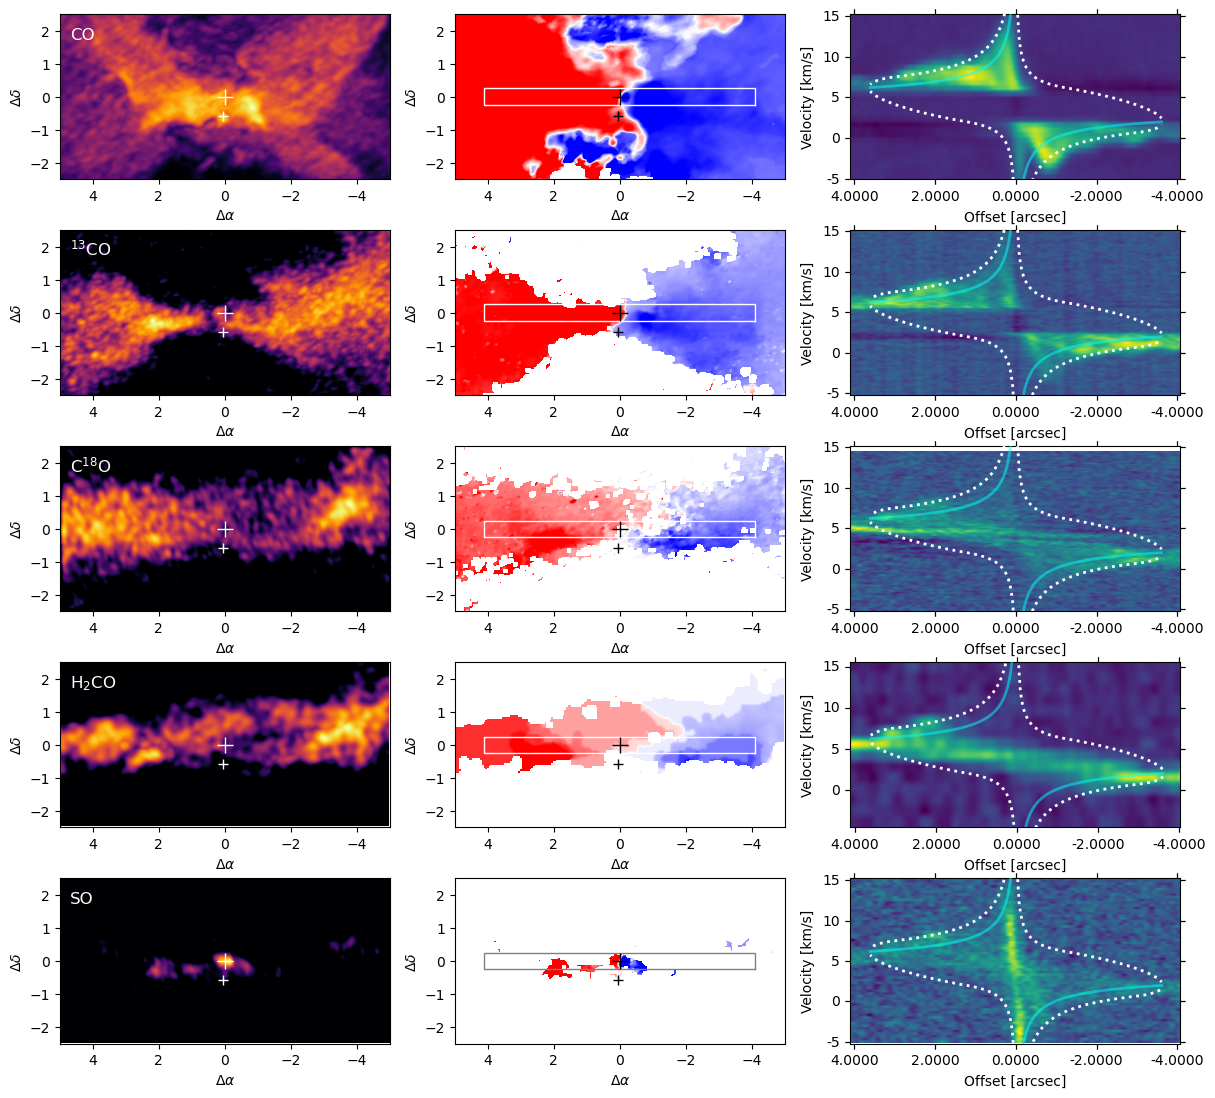

In [8]:
# plot peak temperature, moment1, and PV diagram for each line
fig = plt.figure(figsize=(12,11))
gs = gridspec.GridSpec(5, 3, figure=fig)

for i in range(5):
    filename = path + obs['line'][i] + '.fits'
    #filename = path + 'OphIRS43_SB_' + obs['line'][i] + '_robust_0.5.pbcor.fits' 
    
    if large_scale:
        subcube, extent = make_subcube(filename, vla1, 10*u.arcsec, 5*u.arcsec, 0*u.deg)
    else:
        subcube, extent = make_subcube(filename, vla1, 2*u.arcsec, 1*u.arcsec, 0*u.deg)
    subcube_kms = subcube.with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=obs['restfreq'][i]*u.GHz)
    
    clip = obs['clip'][i]/1000 * u.Jy / u.beam
    mask_3sigma = (subcube_kms > clip).include()
    masked_cube =  subcube_kms.with_mask(mask_3sigma.compute())
    masked_moment0 = subcube_kms.moment0()
    masked_peak = np.max(subcube_kms, axis=0)
    masked_moment1 = masked_cube.moment1()
    
    if obs['smooth'][i]:
        beam = radio_beam.Beam(major=0.25*u.arcsec, minor=0.25*u.arcsec, pa=0*u.deg)
        masked_peak = masked_peak.convolve_to(beam)
        
    # 1st column for moment0 map
    ax0 = fig.add_subplot(gs[i, 0])
    norm = ImageNormalize(masked_peak.value, vmin=clip.value, stretch=AsinhStretch(0.3))
    mom0 = ax0.imshow(masked_peak.value, origin='lower', norm=norm, extent=extent, cmap='inferno', interpolation='bicubic')
    #ax0.arrow(path_dra[0], path_ddec[0], path_dra[1]-path_dra[0], path_ddec[1]-path_ddec[0], head_width=0.2, color='green', lw=3)
    ax0.text(0.03, 0.85, obs['name'][i], fontsize=12, color='white', transform = ax0.transAxes)
    
    # 2nd column for moment1 map
    ax1 = fig.add_subplot(gs[i, 1])
    mom1 = ax1.imshow(masked_moment1.value, origin='lower', vmin=0.0, vmax=6.0, extent=extent, cmap='bwr', interpolation='bicubic')
    #ax1.arrow(path_dra[0], path_ddec[0], path_dra[1]-path_dra[0], path_ddec[1]-path_ddec[0], head_width=0.2, color='green', lw=3, alpha=0.3)
    pv_box_x = [path_dra[0], path_dra[0], path_dra[1], path_dra[1], path_dra[0]]
    y0 = path_ddec[0]
    dy = width / 2
    pv_box_y = [y0-dy, y0+dy, y0+dy, y0-dy, y0-dy]
    if obs['line'][i] == 'so':
        col = 'gray'
    else:
        col = 'white'
    ax1.plot(pv_box_x, pv_box_y, color=col, lw=1, alpha=1)
    
    for ax in [ax0, ax1]:
        if large_scale:
            xmin, xmax = -5, 5
            ymin, ymax = -2.5, 2.5
        else:
            xmin, xmax = -1, 1
            ymin, ymax = -0.5, 0.5        
        ax.set_xlim(xmax, xmin)
        ax.set_ylim(ymin, ymax)
        asp = (ymax - ymin) / (xmax - xmin)
        
        if ax == ax0:
            ax.plot(0, 0, '+', ms=12, mew=1, color='white')
            ax.plot(x_vla2, y_vla2, '+', ms=7, mew=1, color='white')
            ax.plot(x_td, y_td, '+', ms=7, mew=1, color='white')
        else:
            ax.plot(0, 0, '+', ms=12, mew=1, color='black')
            ax.plot(x_vla2, y_vla2, '+', ms=7, mew=1, color='black')
            ax.plot(x_td, y_td, '+', ms=7, mew=1, color='black')
        ax.set_ylabel(r'$\Delta\delta$')
        ax.set_xlabel(r'$\Delta\alpha$')
        
    # 3rd column is the pv-diagram with adjust aspect ratio
    pvdiagram = extract_pv_slice(cube=subcube_kms, path=skypath)
    ww = wcs.WCS(pvdiagram.header)
    ww.wcs.crval[0] = path_start_offset.value
    ww.wcs.cdelt[0] *= -1
    kmin = (1000*Vmin - ww.wcs.crval[1]) / ww.wcs.cdelt[1] + ww.wcs.crpix[1]
    kmax = (1000*Vmax - ww.wcs.crval[1]) / ww.wcs.cdelt[1] + ww.wcs.crpix[1]
    kcen = 0.5 * (kmin + kmax)
    ksiz = int(kmax - kmin)
    nx = pvdiagram.header['NAXIS1']
    nv = pvdiagram.header['NAXIS2']
    position = (nx/2, kcen)
    size = (ksiz, nx)
    cutout = Cutout2D(pvdiagram.data, position, size, mode='partial', wcs=ww)   
    ax2 = fig.add_subplot(gs[i, 2], projection=cutout.wcs)
    im = ax2.imshow(cutout.data, aspect=asp*nx/ksiz)

    # fix the axes limits so the next plots don't autoscale
    ax2.set_xlim(ax2.get_xlim())
    ax2.set_ylim(ax2.get_ylim())
    #ax2.grid()
    
    # pure Keplerian
    Vsys = 4.1
    dist = 137.3
    R, VKep = Kepler(2.5, 1, 500)
    xpix, ypix = cutout.wcs.world_to_pixel_values(R/dist/3600, (Vsys+VKep)*1000)
    ax2.plot(xpix, ypix, color='cyan', ls='-', lw=2, alpha=0.5)
    xpix, ypix = cutout.wcs.world_to_pixel_values(-R/dist/3600, (Vsys-VKep)*1000)
    ax2.plot(xpix, ypix, color='cyan', ls='-', lw=2, alpha=0.5)
    
    # Cesaroni infall + rotation fit
    R, Vbound_min, Vbound_max = bound_velocities(2.5, 1, 500)
    xpix, ypix = cutout.wcs.world_to_pixel_values(R/dist/3600, (Vsys+Vbound_min)*1000)
    ax2.plot(xpix, ypix, color='white', ls=':', lw=2, alpha=1)
    xpix, ypix = cutout.wcs.world_to_pixel_values(R/dist/3600, (Vsys+Vbound_max)*1000)
    ax2.plot(xpix, ypix, color='white', ls=':', lw=2, alpha=1)
    xpix, ypix = cutout.wcs.world_to_pixel_values(-R/dist/3600, (Vsys-Vbound_max)*1000)
    ax2.plot(xpix, ypix, color='white', ls=':', lw=2, alpha=1)
    xpix, ypix = cutout.wcs.world_to_pixel_values(-R/dist/3600, (Vsys-Vbound_min)*1000)
    ax2.plot(xpix, ypix, color='white', ls=':', lw=2, alpha=1)
    
    ax2.coords[0].set_format_unit(u.arcsec)
    #ax2.coords[0].set_major_formatter('%5.2f')
    ax2.coords[1].set_format_unit(u.km/u.s)
    ax2.set_ylabel("Velocity [km/s]")
    ax2.set_xlabel("Offset [arcsec]")
        
gs.tight_layout(fig)

In [9]:
fig.savefig('moments_pv.pdf')